<a href="https://colab.research.google.com/github/LeonardoBusculo/Previs-o-de-usu-rios-com-alta-chance-de-deixar-seu-Streaming/blob/main/DESAFIO_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install sidetable -q

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sidetable as stb
import statistics as sts
import warnings

from sklearn.cluster import(KMeans, DBSCAN, MeanShift, AgglomerativeClustering,)
from sklearn.mixture import GaussianMixture

from sklearn.metrics import(silhouette_score, davies_bouldin_score, calinski_harabasz_score)

from scipy.cluster.hierarchy import (linkage, dendrogram, fcluster)

from yellowbrick.cluster import (KElbowVisualizer, SilhouetteVisualizer, kelbow_visualizer, silhouette_visualizer)

from sklearn.preprocessing import (StandardScaler, scale, PowerTransformer)

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette = 'viridis', alpha = 0.8, linewidth = 0)

In [ ]:
df = pd.read_csv(r"/content/data (1).csv", encoding = "latin1")
print(df.shape)
df.head()

(301296, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(301296, 8)

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,UnitPrice,CustomerID
count,301295.000000,301295.000000,216796.000000
mean,9.564842,4.951907,15279.453804
std,200.141068,115.968847,1730.020555
min,-74215.000000,-11062.060000,12346.000000
1%,-2.000000,0.210000,12412.000000
10%,1.000000,0.650000,12867.000000
25%,1.000000,1.250000,13850.000000
50%,3.000000,2.100000,15140.000000
75%,10.000000,4.130000,16818.000000
90%,24.000000,7.950000,17722.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301296 entries, 0 to 301295
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    301296 non-null  object 
 1   StockCode    301296 non-null  object 
 2   Description  300186 non-null  object 
 3   Quantity     301295 non-null  float64
 4   InvoiceDate  301295 non-null  object 
 5   UnitPrice    301295 non-null  float64
 6   CustomerID   216796 non-null  float64
 7   Country      301295 non-null  object 
dtypes: float64(3), object(5)
memory usage: 18.4+ MB


In [ ]:
df.isna().sum()

InvoiceNo          0
StockCode          0
Description     1110
Quantity           1
InvoiceDate        1
UnitPrice          1
CustomerID     84500
Country            1
dtype: int64

In [ ]:
(
df.isna().sum()
.to_frame("Valores NA")
.assign(missing_pct = lambda x:x.div(len(df)))
.sort_values("Valores NA",ascending = False))

,Valores NA,missing_pct
CustomerID,84500,0.280455
Description,1110,0.003684
Quantity,1,0.000003
InvoiceDate,1,0.000003
UnitPrice,1,0.000003
Country,1,0.000003
InvoiceNo,0,0.000000
StockCode,0,0.000000


In [ ]:
df.loc[df["UnitPrice"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1.0,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1.0,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
df.loc[df["Quantity"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1.0,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1.0,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12.0,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24.0,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24.0,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
300952,C563226,23253,16 PIECE CUTLERY SET PANTRY DESIGN,-1.0,8/14/2011 14:36,15.95,13116.0,United Kingdom
301031,C563232,23173,REGENCY TEAPOT ROSES,-1.0,8/14/2011 15:55,9.95,17988.0,United Kingdom
301108,C563240,22616,PACK OF 12 LONDON TISSUES,-12.0,8/15/2011 10:06,0.29,15048.0,United Kingdom
301165,563244,22740,NaN,-36.0,8/15/2011 10:49,0.00,NaN,United Kingdom


In [ ]:
df.duplicated().sum()

2345

In [ ]:
df.stb.freq(["Country"]).head(10)

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,275774,91.529564,275774,91.529564
1,Germany,5354,1.776996,281128,93.306560
2,EIRE,4311,1.430824,285439,94.737384
3,France,4239,1.406927,289678,96.144310
4,Netherlands,1487,0.493536,291165,96.637847
5,Spain,1364,0.452712,292529,97.090559
6,Belgium,1175,0.389983,293704,97.480542
7,Switzerland,1154,0.383013,294858,97.863556
8,Australia,899,0.298379,295757,98.161934
9,Portugal,755,0.250585,296512,98.412519


In [ ]:
(df.groupby(df.columns.to_list(), dropna = False)
 .size()
 .to_frame("duplicates")
 .query("duplicates > 1")
 .sort_values("duplicates", ascending = False)
 )

duplicates
InvoiceNo StockCode Description                      Quantity InvoiceDate     UnitPrice CustomerID Country                   
555524    22698     PINK REGENCY TEACUP AND SAUCER    1.0     6/5/2011 11:37  2.95      16923.0    United Kingdom          20
          22697     GREEN REGENCY TEACUP AND SAUCER   1.0     6/5/2011 11:37  2.95      16923.0    United Kingdom          12
541266    21755     LOVE BUILDING BLOCK WORD          1.0     1/16/2011 16:25 5.95      15673.0    United Kingdom           6
          21754     HOME BUILDING BLOCK WORD          1.0     1/16/2011 16:25 5.95      15673.0    United Kingdom           6
540524    21756     BATH BUILDING BLOCK WORD          1.0     1/9/2011 12:53  5.95      16735.0    United Kingdom           6
...                                                                                                                       ...
543639    21531     RED RETROSPOT SUGAR JAM BOWL      1.0     2/10/2011 16:52 2.55      16725.0    United Kingdom           2
          21216     SET 3 RETROSPOT TEA,COFFEE,SUGAR  1.0     2/10/2011 16:52 4.95      16725.0    United Kingdom           2
543631    85017C    ENVELOPE 50 CURIOUS IMAGES        1.0     2/10/2011 16:17 0.85      14081.0    United Kingdom           2
          21535     RED RETROSPOT SMALL MILK JUG      2.0     2/10/2011 16:17 2.55      14081.0    United Kingdom           2
C562582   21452     TOADSTOOL MONEY BOX              -1.0     8/7/2011 13:53  2.95      15640.0    United Kingdom           2

[2162 rows x 1 columns]

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format = '%m/%d/%Y %H:%M').dt.date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format = '%Y-%m-%d')

df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850.0,United Kingdom


In [ ]:
df["CustomerID"] = df["CustomerID"].astype("Int64")
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              Int64
Country                object
dtype: object

In [ ]:
df1 = df.dropna(axis = 0, how = "any")
actual = len(df)-len(df1)

print(f"Foram removidos no total {actual} de linhas")

Foram removidos no total 84500 de linhas


In [ ]:
df1.stb.missing()

,missing,total,percent
InvoiceNo,0,216796,0.0
StockCode,0,216796,0.0
Description,0,216796,0.0
Quantity,0,216796,0.0
InvoiceDate,0,216796,0.0
UnitPrice,0,216796,0.0
CustomerID,0,216796,0.0
Country,0,216796,0.0


In [ ]:
df1 = df1.loc[df1["Quantity"]>0]
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
301290,563253,85099B,JUMBO BAG RED RETROSPOT,20.0,2011-08-15,2.08,15218,United Kingdom
301291,563253,23200,JUMBO BAG PEARS,10.0,2011-08-15,2.08,15218,United Kingdom
301292,563253,23199,JUMBO BAG APPLES,10.0,2011-08-15,2.08,15218,United Kingdom
301293,563253,23203,JUMBO BAG VINTAGE DOILY,20.0,2011-08-15,2.08,15218,United Kingdom


In [ ]:
df1.drop_duplicates(keep = "first", inplace = True)
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
301290,563253,85099B,JUMBO BAG RED RETROSPOT,20.0,2011-08-15,2.08,15218,United Kingdom
301291,563253,23200,JUMBO BAG PEARS,10.0,2011-08-15,2.08,15218,United Kingdom
301292,563253,23199,JUMBO BAG APPLES,10.0,2011-08-15,2.08,15218,United Kingdom
301293,563253,23203,JUMBO BAG VINTAGE DOILY,20.0,2011-08-15,2.08,15218,United Kingdom


In [ ]:
df1 = df1.loc[df1["UnitPrice"]>0]
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
301290,563253,85099B,JUMBO BAG RED RETROSPOT,20.0,2011-08-15,2.08,15218,United Kingdom
301291,563253,23200,JUMBO BAG PEARS,10.0,2011-08-15,2.08,15218,United Kingdom
301292,563253,23199,JUMBO BAG APPLES,10.0,2011-08-15,2.08,15218,United Kingdom
301293,563253,23203,JUMBO BAG VINTAGE DOILY,20.0,2011-08-15,2.08,15218,United Kingdom


In [ ]:
df1.groupby("Country").size()

Country
Australia                  827
Austria                    237
Bahrain                     17
Belgium                   1154
Brazil                      32
Canada                     146
Channel Islands            376
Cyprus                     349
Czech Republic              15
Denmark                    217
EIRE                      3732
European Community          60
Finland                    431
France                    4148
Germany                   5053
Greece                     109
Iceland                    124
Israel                      43
Italy                      382
Japan                      269
Lebanon                     45
Lithuania                   35
Malta                       45
Netherlands               1484
Norway                     494
Poland                     227
Portugal                   740
Saudi Arabia                 9
Singapore                  188
Spain                     1349
Sweden                     258
Switzerland               1082


In [ ]:
df1 = df1.loc[~(df1["Country"]=="Unspecified")]
df1.groupby("Country").size()

Country
Australia                  827
Austria                    237
Bahrain                     17
Belgium                   1154
Brazil                      32
Canada                     146
Channel Islands            376
Cyprus                     349
Czech Republic              15
Denmark                    217
EIRE                      3732
European Community          60
Finland                    431
France                    4148
Germany                   5053
Greece                     109
Iceland                    124
Israel                      43
Italy                      382
Japan                      269
Lebanon                     45
Lithuania                   35
Malta                       45
Netherlands               1484
Norway                     494
Poland                     227
Portugal                   740
Saudi Arabia                 9
Singapore                  188
Spain                     1349
Sweden                     258
Switzerland               1082


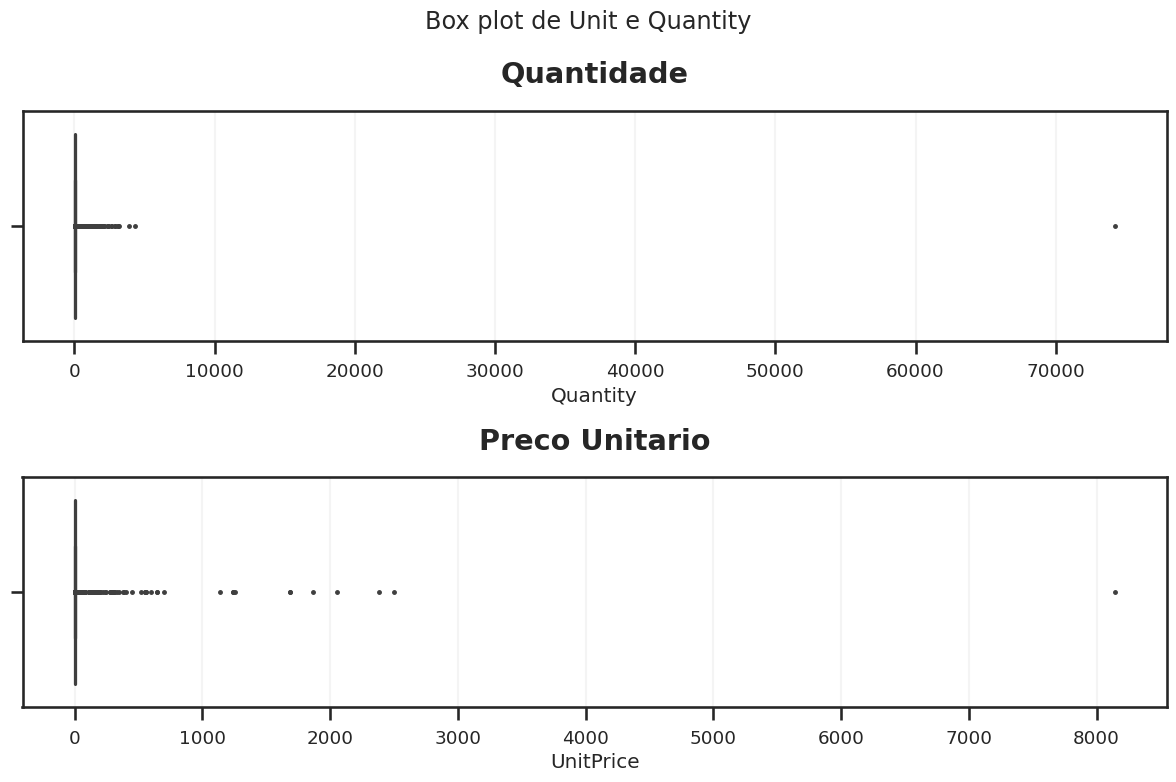

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, top = 0.85)
fig.suptitle("Box plot de Unit e Quantity")
ax1 = fig.add_subplot(2,1,1)
sns.boxplot(df1, x = "Quantity", orient = "h", flierprops = {"marker": "."}).set(title = "Quantidade")
ax1 = fig.add_subplot(2,1,2)
sns.boxplot(df1, x = "UnitPrice", orient = "h", flierprops = {"marker": "."}).set(title = "Preco Unitario")
plt.tight_layout();

In [ ]:
df1.query("UnitPrice > 5000 | Quantity > 10000")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,2011-01-18,1.04,12346,United Kingdom
173382,551697,POST,POSTAGE,1.0,2011-05-03,8142.75,16029,United Kingdom


In [ ]:
#removendo os outliers de UNIT PRICE acima de 5000 e Quantity acima de 10000
df1 = df1.loc[~(df1["Quantity"] > 10000)]
df1 = df1.loc[~(df1["UnitPrice"]> 5000)]

In [ ]:
df1.query("UnitPrice > 5000 | Quantity > 10000")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


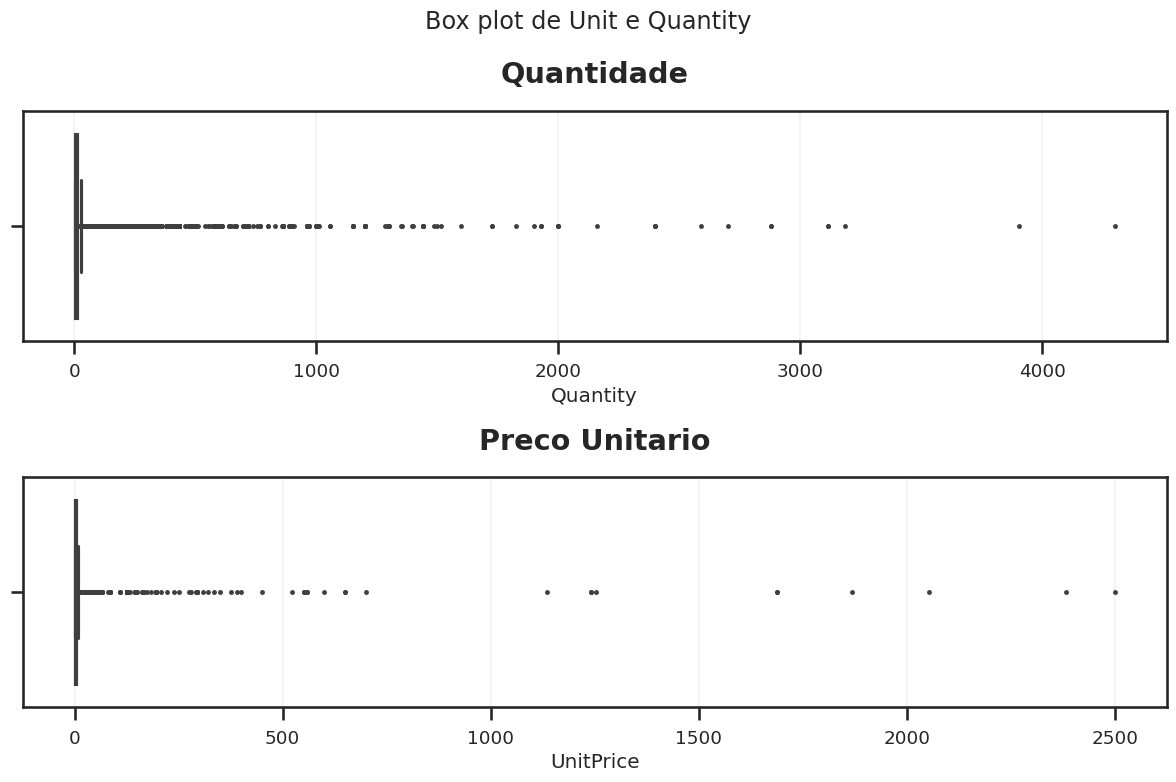

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, top = 0.85)
fig.suptitle("Box plot de Unit e Quantity")
ax1 = fig.add_subplot(2,1,1)
sns.boxplot(df1, x = "Quantity", orient = "h", flierprops = {"marker": "."}).set(title = "Quantidade")
ax1 = fig.add_subplot(2,1,2)
sns.boxplot(df1, x = "UnitPrice", orient = "h", flierprops = {"marker": "."}).set(title = "Preco Unitario")
plt.tight_layout();

In [ ]:
df1.describe(percentiles = [.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,UnitPrice,CustomerID
count,209054.000000,209054.000000,209054.0
mean,13.322242,3.184884,15282.298617
std,46.121467,13.970394,1729.697101
min,1.000000,0.001000,12347.0
1%,1.000000,0.290000,12412.0
10%,1.000000,0.550000,12872.0
25%,2.000000,1.250000,13854.0
50%,6.000000,1.950000,15144.0
75%,12.000000,3.750000,16833.0
90%,24.000000,6.950000,17725.0


In [ ]:
df1["total"] = df1.apply(lambda x : x["UnitPrice"] * x["Quantity"] , axis = 1)

In [ ]:
df1.reset_index(drop = True, inplace = True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom,20.34


In [ ]:
primeira_compra = min(df1["InvoiceDate"])
ultima_compra = max(df1["InvoiceDate"])
print(f"A primeira compra foi no dia {primeira_compra} , ja a ultima compra foi no dia {ultima_compra}")

A primeira compra foi no dia 2010-12-01 00:00:00 , ja a ultima compra foi no dia 2011-08-15 00:00:00


In [ ]:
def top_country(df1:pd.DataFrame, n:int)->pd.DataFrame:
    topcountry = (
        df1
        .groupby("Country")
        .agg({"total":"sum"})
        .rename({"total":"total"})
        .sort_values(by = "total", ascending = False)
        .reset_index()
        .head(n)
    )
    return topcountry

topcountry = top_country(df1, 10)
topcountry

,Country,total
0,United Kingdom,3874640.102
1,Netherlands,172345.560
2,EIRE,158571.060
3,Germany,129237.940
4,France,103009.820
5,Australia,87073.390
6,Spain,36272.130
7,Switzerland,31716.360
8,Japan,26896.170
9,Sweden,24536.970


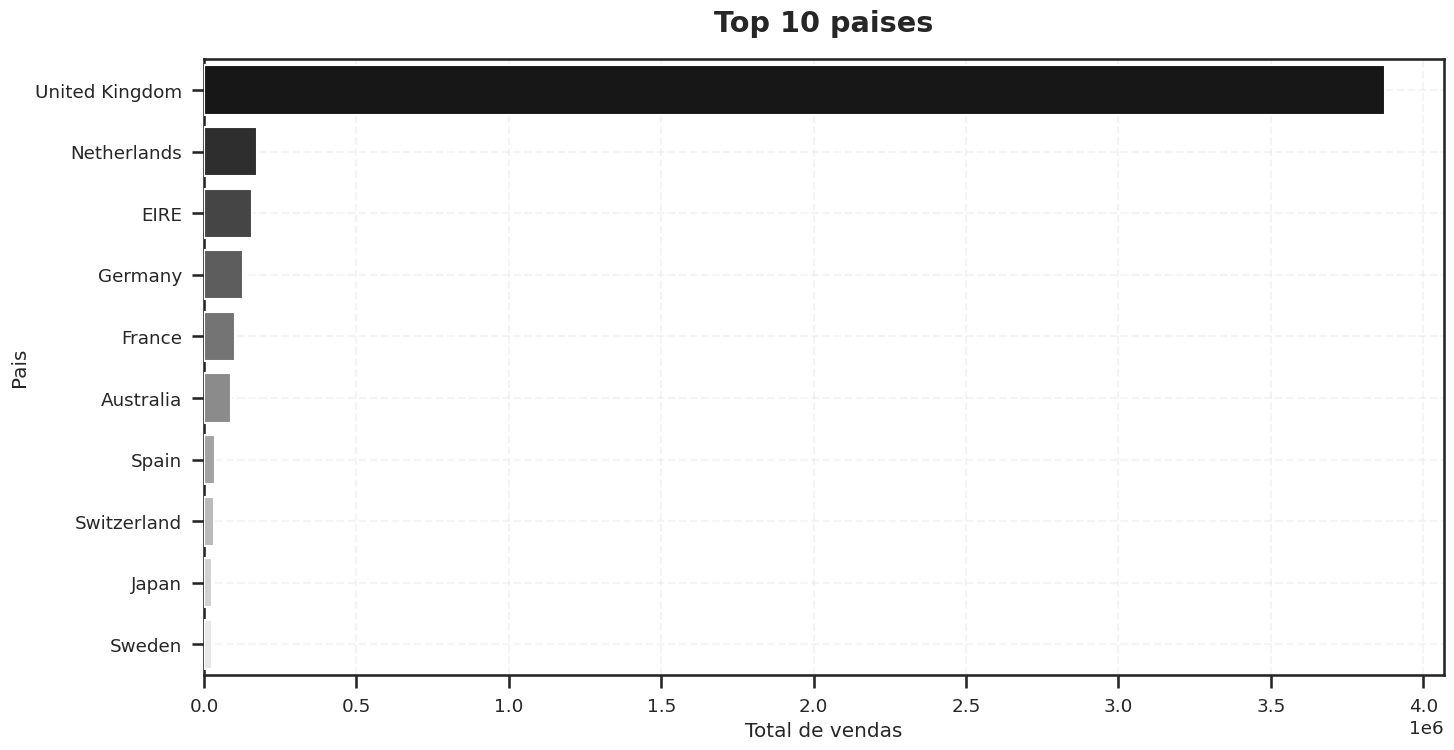

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8))
sns.barplot(data = topcountry, x = 'total', y = 'Country', ax = ax, palette = "gray", zorder = 10)
ax.set_xlabel('Total de vendas')
ax.set_ylabel('Pais')
ax.set_title("Top 10 paises")
ax.grid(True, linestyle = '--', zorder = 10);

In [ ]:
def recomend_products(df:pd.DataFrame, n:int, agg_fun = sum  )->pd.DataFrame:
    topproducts = (
        df1
        .groupby("Description")
        .agg({"Quantity":agg_fun})
        .sort_values("Quantity", ascending = False)
        .rename({"Quantity":"Quantidade"})
        .reset_index()
        .head(n)
    )
    return topproducts

topproducts = recomend_products(df1, 10, agg_fun = "sum")
topproducts

,Description,Quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,35476.0
1,JUMBO BAG RED RETROSPOT,27098.0
2,WHITE HANGING HEART T-LIGHT HOLDER,25923.0
3,PACK OF 72 RETROSPOT CAKE CASES,23657.0
4,ASSORTED COLOUR BIRD ORNAMENT,21791.0
5,ASSORTED COLOURS SILK FAN,19488.0
6,PACK OF 12 LONDON TISSUES,18434.0
7,SMALL POPCORN HOLDER,18093.0
8,PACK OF 60 PINK PAISLEY CAKE CASES,17233.0
9,BROCADE RING PURSE,15830.0


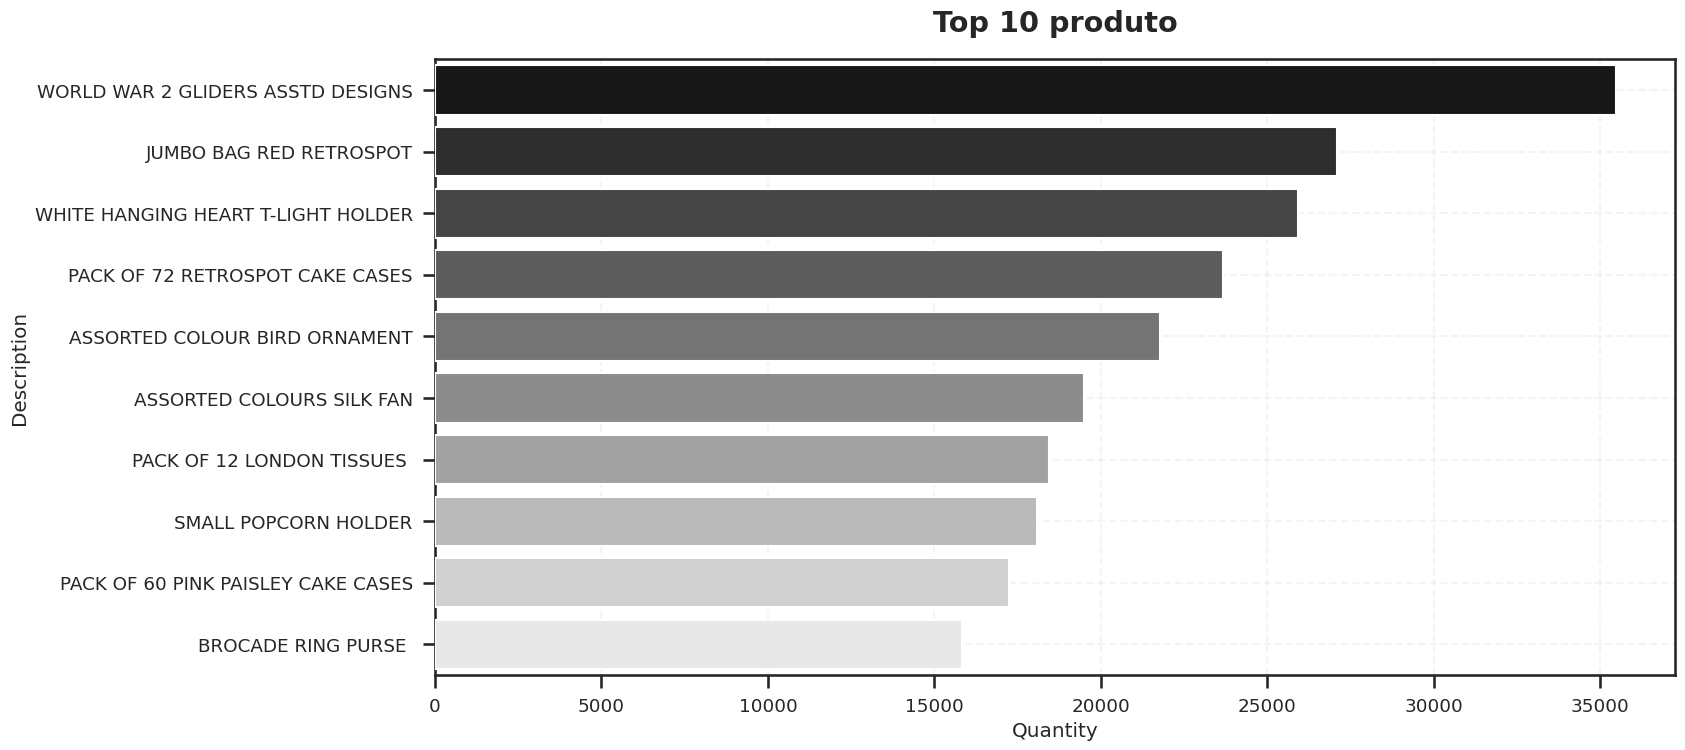

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8))
sns.barplot(data = topproducts, x = 'Quantity', y = 'Description', ax = ax, palette = "gray", zorder = 10)
ax.set_xlabel('Quantity')
ax.set_ylabel('Description')
ax.set_title("Top 10 produto")
ax.grid(True, linestyle='--', zorder = 10)

In [ ]:
def total_mes(df1:pd.DataFrame)->pd.DataFrame:
    totalmes = (
        df1
        .groupby("InvoiceDate")
        .agg({"total":"sum"})
        .reset_index()

 )
    return totalmes


totalmes = total_mes(df1)

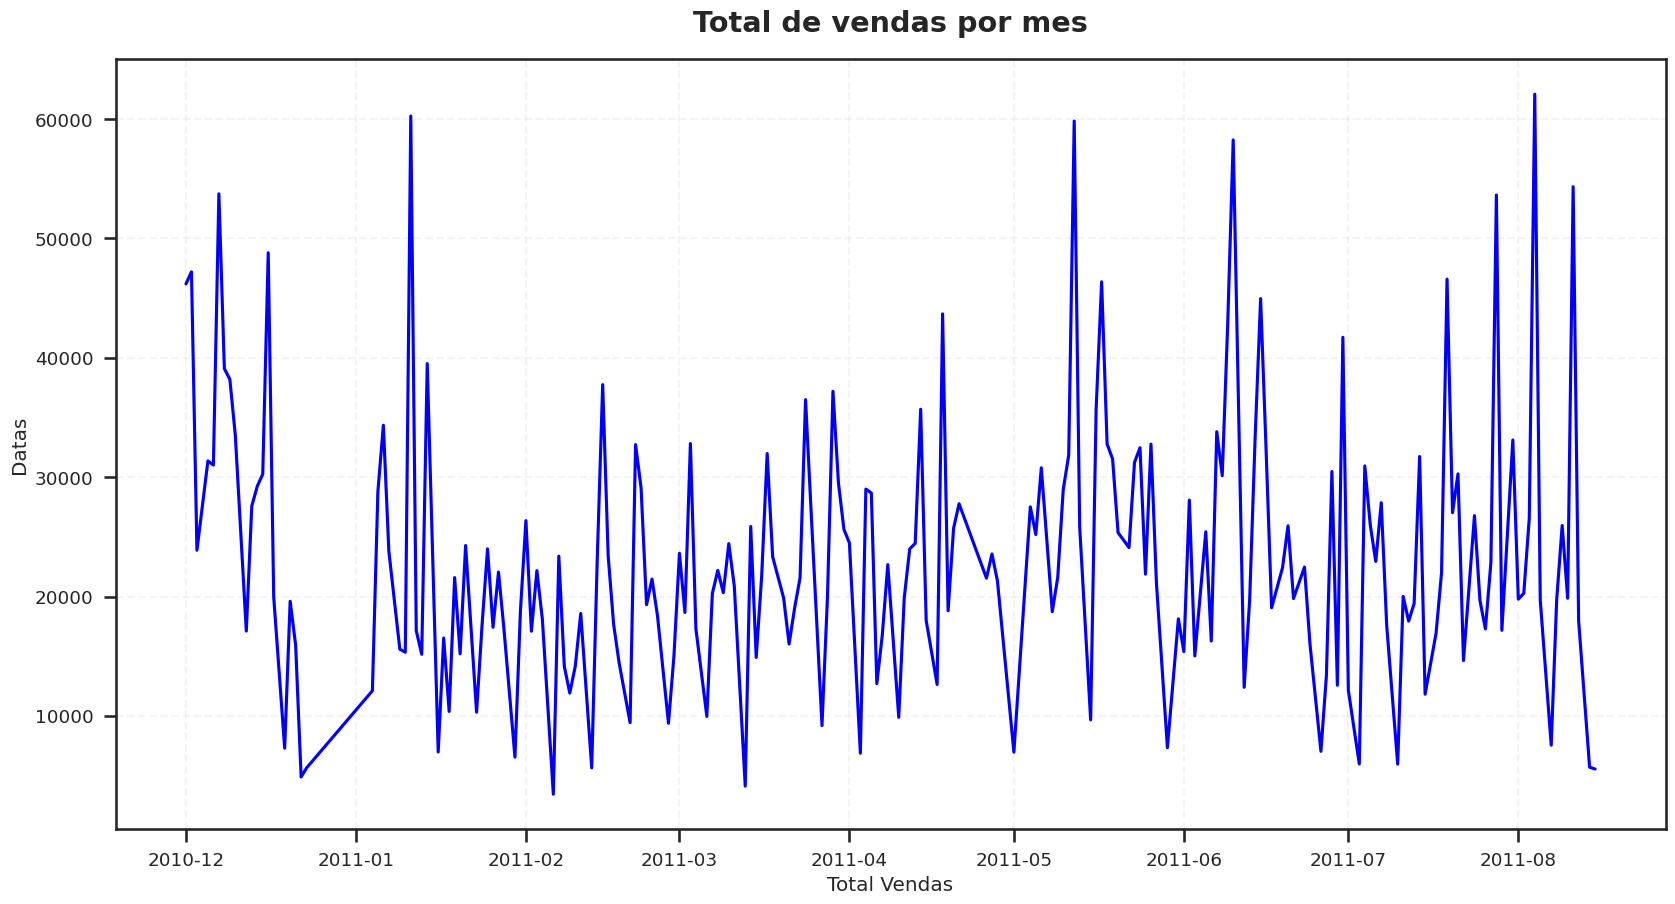

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
sns.lineplot(data = totalmes, x = "InvoiceDate", y = "total", ax = ax, color = 'blue', zorder = 10)
ax.set_xlabel('Total Vendas')
ax.set_ylabel('Datas')
ax.set_title("Total de vendas por mes")
ax.grid(True, linestyle='--', zorder = 10)

In [ ]:
def vendamespais(df:pd.DataFrame, n:int)->pd.DataFrame:
    vendatotalpais = (
        df1
        .groupby(["InvoiceDate", "Country"])
        .agg({"total":"sum"})
        .sort_values(by = "total", ascending = False)
        .reset_index()
        .head(n)
)
    return vendatotalpais

vendatotalpais = vendamespais(df1, 10)
vendatotalpais

,InvoiceDate,Country,total
0,2011-08-04,United Kingdom,53721.53
1,2011-01-11,United Kingdom,53560.03
2,2010-12-07,United Kingdom,50973.39
3,2011-06-10,United Kingdom,50930.64
4,2010-12-16,United Kingdom,47187.06
5,2010-12-02,United Kingdom,47019.72
6,2011-07-28,United Kingdom,46566.03
7,2010-12-01,United Kingdom,42049.78
8,2011-04-18,United Kingdom,40229.84
9,2011-06-30,United Kingdom,37828.90


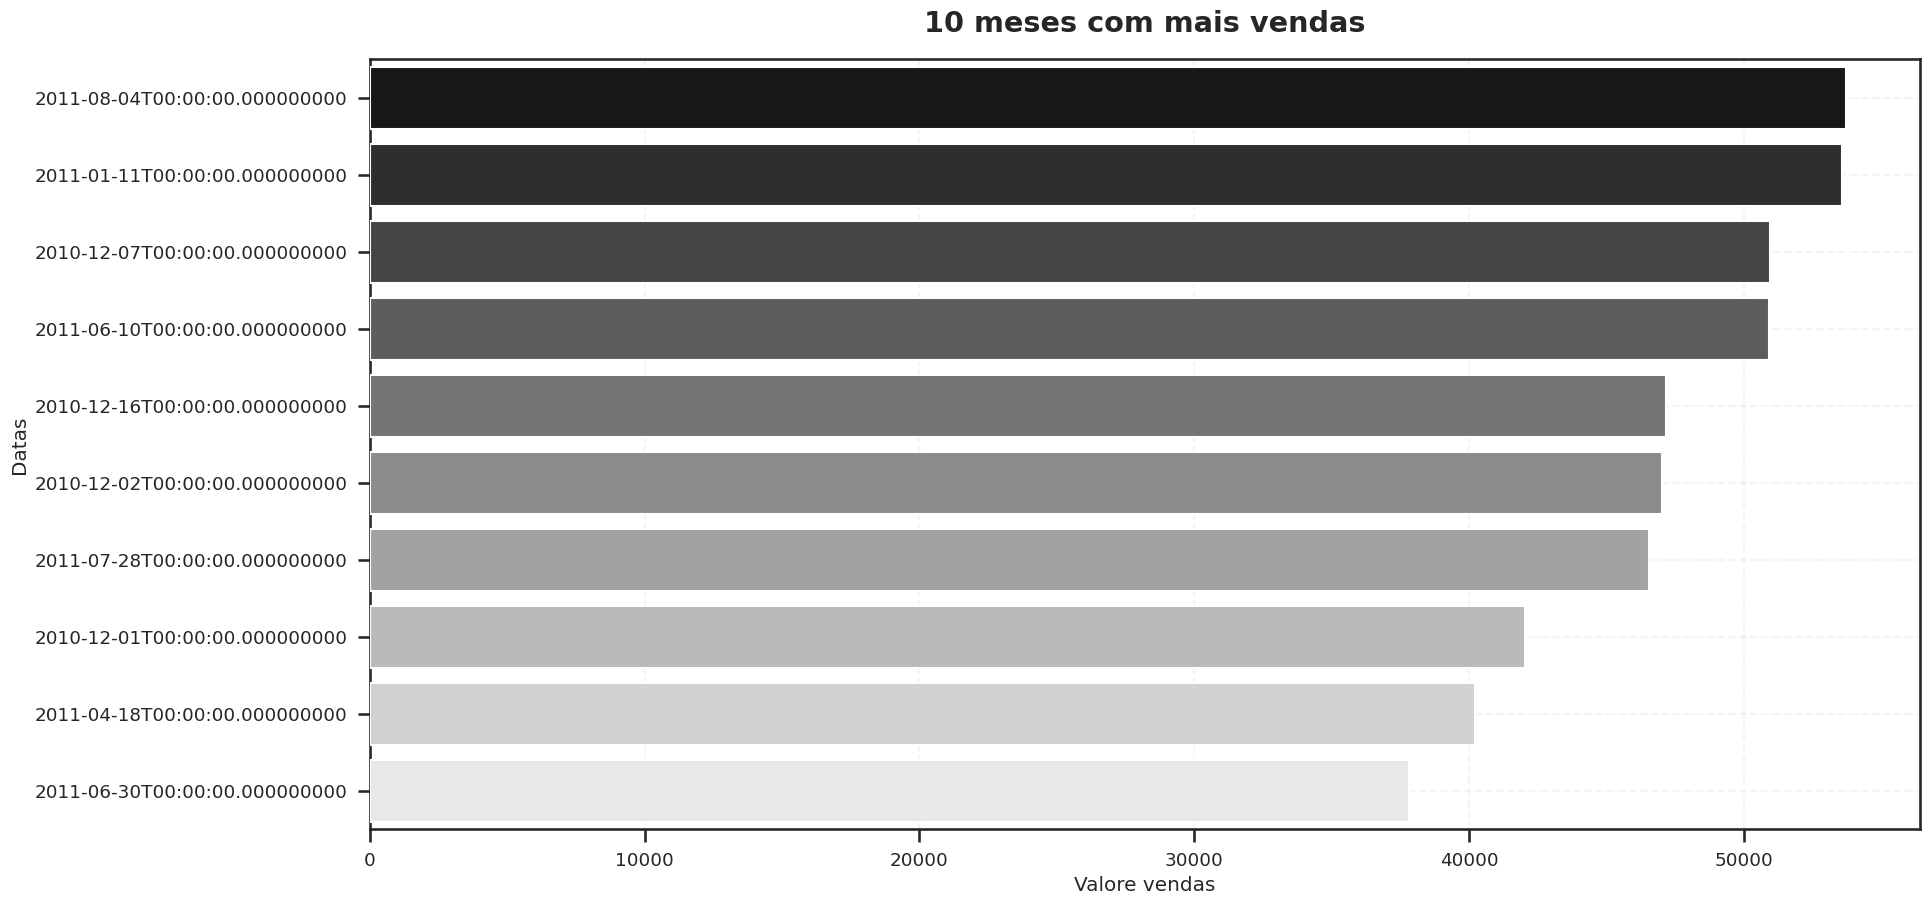

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
sns.barplot(data = vendatotalpais, x = "total", y = "InvoiceDate", ax = ax, palette = 'gray', zorder = 10)
ax.set_xlabel('Valore vendas')
ax.set_ylabel('Datas')
ax.set_title("10 meses com mais vendas")
ax.grid(True, linestyle = '--', zorder = 10)

In [ ]:
df1.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom,15.3


In [ ]:
df1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              Int64
Country                object
total                 float64
dtype: object

In [ ]:
def rfm()->pd.DataFrame:
  rfm=(df1
  .groupby("CustomerID")
  .agg({"InvoiceDate":lambda x : (pd.Timestamp("2012-01-01") - x.max()).days,
      "InvoiceNo":"nunique",
      "total":lambda x : x.mean()})
  .rename(columns = {"InvoiceDate": "recency", "InvoiceNo": "frequency", "total": "monetary"})
  .reset_index())
  return rfm


rfm = rfm()

In [ ]:
rfm = rfm.set_index("CustomerID")

In [ ]:
rfm_clip = rfm.apply(lambda x:x.clip(upper = x.quantile(0.95)))

In [ ]:
rfm_clip_scaled = rfm_clip.apply(scale).copy()

In [ ]:
rfm["r_rank"] = rfm["recency"].rank(ascending = False)
rfm["f_rank"] = rfm["frequency"].rank(ascending = True)
rfm["m_rank"] = rfm["monetary"].rank(ascending = True)
rfm

,recency,frequency,monetary,r_rank,f_rank,m_rank
CustomerID,,,,,,
12347,152,5,22.506935,2785.0,2699.5,2209.0
12348,271,3,53.115714,836.0,2200.5,2895.0
12350,333,1,19.670588,365.0,680.0,1910.0
12352,285,5,41.100263,701.0,2699.5,2797.0
12353,227,1,22.250000,1308.5,680.0,2187.0
...,...,...,...,...,...,...
18280,300,1,18.060000,572.5,680.0,1654.0
18281,203,1,11.545714,1665.0,680.0,707.0
18282,149,1,14.315714,2933.5,680.0,921.0


In [ ]:
norm = (
  rfm.agg({"r_rank": lambda x:x.div(rfm["r_rank"].max())*100,
         "f_rank": lambda x:x.div(rfm["f_rank"].max())*100,
         "m_rank": lambda x:x.div(rfm["m_rank"].max())*100
         })
      .rename(columns = {"r_rank":"r_norm", "f_rank":"f_norm", "m_rank":"m_norm"}))



rfm = (pd.concat([rfm, norm], axis = 1)
.drop(columns = ["r_rank", "f_rank", "m_rank"]))

In [ ]:
rfm.head()

,recency,frequency,monetary,r_norm,f_norm,m_norm
CustomerID,,,,,,
12347,152,5,22.506935,86.665629,83.809376,68.581186
12348,271,3,53.115714,26.015248,68.317293,89.878920
12350,333,1,19.670588,11.358332,21.111456,59.298355
12352,285,5,41.100263,21.814221,83.809376,86.836386
12353,227,1,22.250000,40.718842,21.111456,67.898168


In [ ]:
rfm["Score"] = rfm.apply(lambda row :0.15*row["r_norm"]+0.28*row["f_norm"]+0.57*row["m_norm"], axis = 1 )
rfm['Score'] * = 0.05 # rfm["Score"].apply(lambda x:x * 0.05)
rfm = rfm[["monetary", "Score"]].sort_values(by = "Score", ascending = False)


In [ ]:
rfm

,monetary,Score
CustomerID,,
17949,940.990222,4.950084
16013,324.663667,4.944696
18102,826.185000,4.915806
17381,187.507222,4.909598
17857,467.478095,4.908027
...,...,...
15012,3.626154,0.342835
14396,3.245588,0.336828
15503,2.136970,0.330306


In [ ]:
rfm["segment"] = (
np.where(rfm["Score"]>4.5, "TopCustomer",
(np.where(rfm["Score"] >4 , "HighValue",
(np.where(rfm["Score"]>3, "Medium customer",
(np.where(rfm["Score"]>1.6, "Low Customer", "LostCustomer"))))))))
rfm

,monetary,Score,segment
CustomerID,,,
17949,940.990222,4.950084,TopCustomer
16013,324.663667,4.944696,TopCustomer
18102,826.185000,4.915806,TopCustomer
17381,187.507222,4.909598,TopCustomer
17857,467.478095,4.908027,TopCustomer
...,...,...,...
15012,3.626154,0.342835,LostCustomer
14396,3.245588,0.336828,LostCustomer
15503,2.136970,0.330306,LostCustomer


In [ ]:
def segmentacao(df:pd.DataFrame):
    segment = (
    rfm
    .groupby("segment")
    .agg({"monetary":"mean"})
    .sort_values(by = "monetary", ascending = False)
    .reset_index()
)
    return segment

segment = segmentacao(rfm)
segment

,segment,monetary
0,HighValue,178.307762
1,TopCustomer,167.860954
2,Medium customer,63.626997
3,Low Customer,17.863865
4,LostCustomer,9.225629


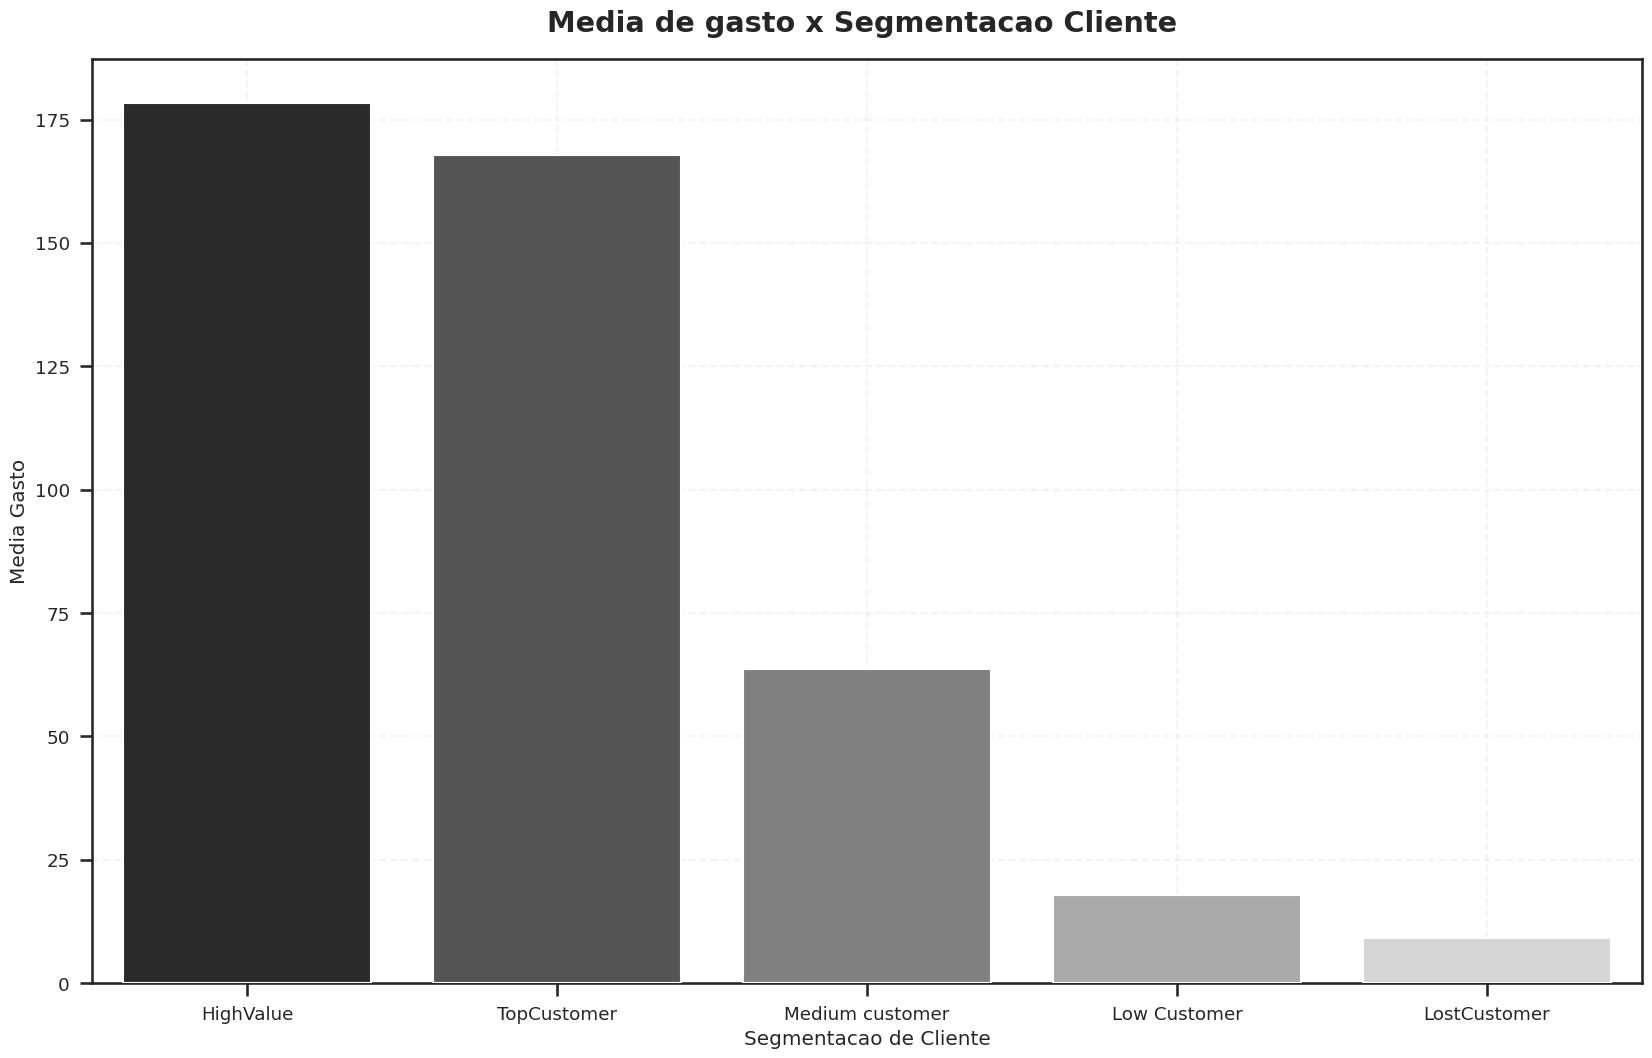

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,12))
sns.barplot(data = segment, x = 'segment', y = 'monetary', ax = ax, palette = 'gray', zorder = 10)
ax.set_xlabel('Segmentacao de Cliente')
ax.set_ylabel('Media Gasto')
ax.set_title("Media de gasto x Segmentacao Cliente ")
ax.grid(True, linestyle = '--', zorder = 10)

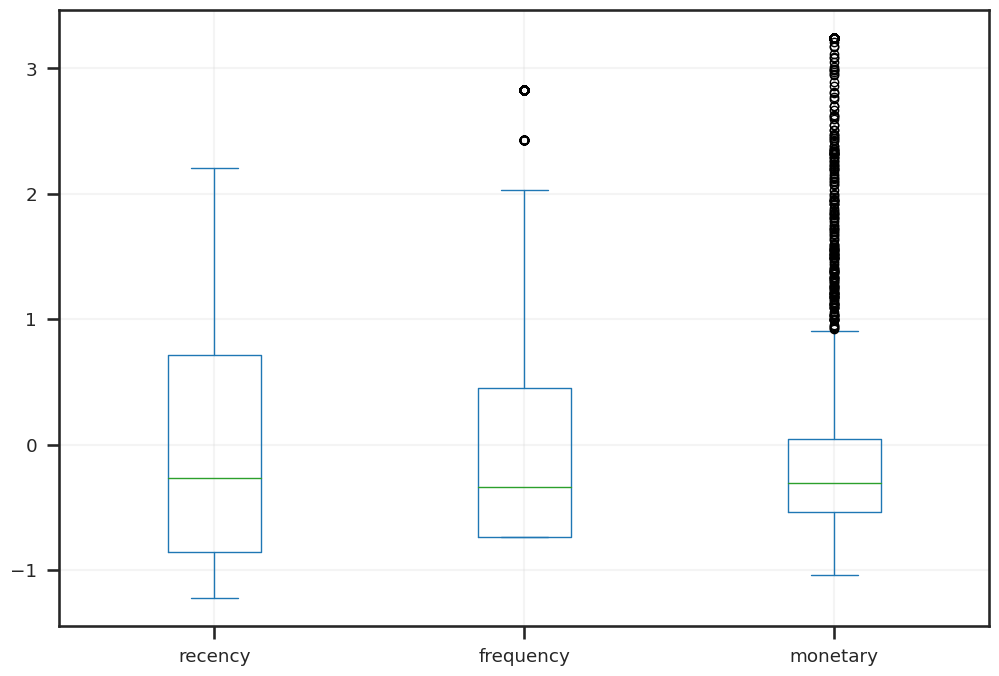

In [ ]:
rfm_clip_scaled.plot.box();

In [ ]:
rfm_clip_scaled

,recency,frequency,monetary
CustomerID,,,
12347,-1.037331,0.847851,-0.097645
12348,0.640489,0.057080,1.274202
12350,1.514647,-0.733692,-0.224766
12352,0.837879,0.847851,0.735685
12353,0.020118,-0.733692,-0.109160
...,...,...,...
18280,1.049369,-0.733692,-0.296951
18281,-0.318266,-0.733692,-0.588913
18282,-1.079629,-0.733692,-0.464765


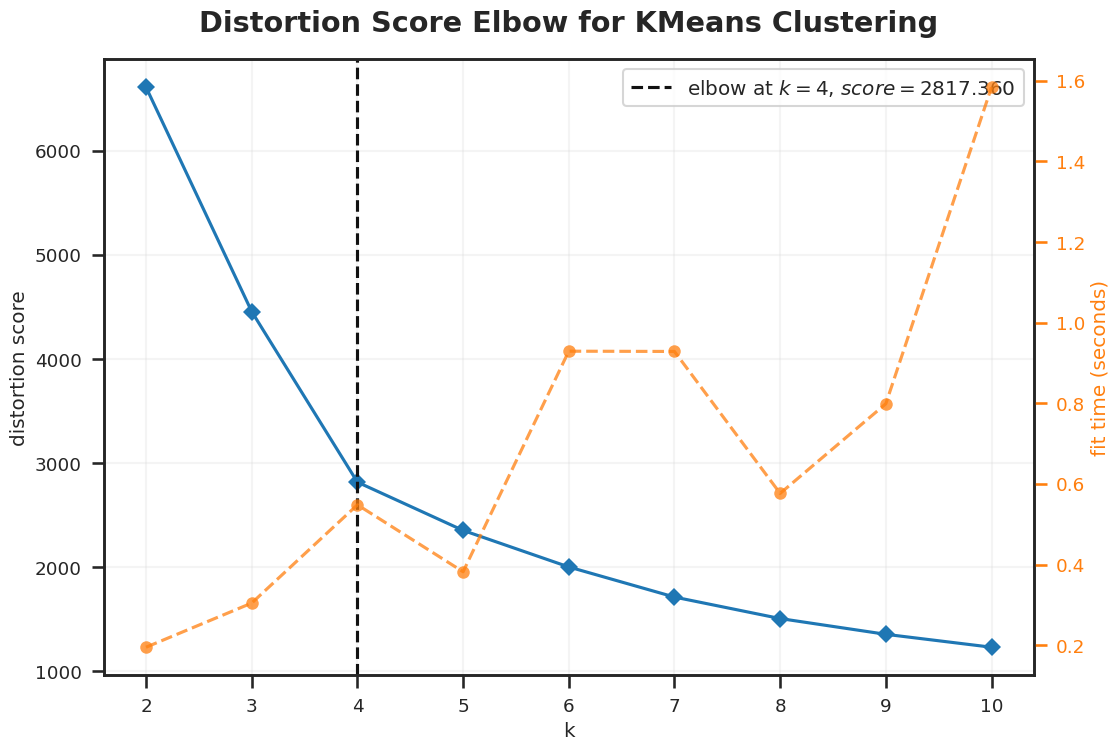

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [ ]:
kelbow_visualizer(KMeans(), rfm_clip_scaled, k = 10, timing = True)

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
x = rfm_clip_scaled

for k in range (2,11):
  model = KMeans(n_clusters = k, random_state = 0)
  labels = model.fit_predict(x)
  cluster_results_dict = {"k": k}
  cluster_results_dict["inertia"] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(x, labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

pd.DataFrame(cluster_metrics_results).set_index("k").style.background_gradient(axis = 0)

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,6612.461538,0.325466,1.212309,1485.079767
3,4455.484945,0.381837,0.928894,1880.595122
4,2817.359610,0.434933,0.758656,2605.563149
5,2353.656624,0.436228,0.765572,2496.848755
6,2002.819478,0.347108,0.890397,2459.281093
7,1713.519259,0.353312,0.871767,2485.137534
8,1507.008763,0.350644,0.929195,2484.127807
9,1363.909811,0.350908,0.860316,2443.093632
10,1231.892167,0.327452,0.914899,2441.838391


In [ ]:
KMeans = KMeans(4)
centroids = model.cluster_centers_
Kmeans_labels = KMeans.fit_predict(rfm_clip_scaled)

In [ ]:
px.scatter_3d(data_frame = rfm_clip, x = "frequency", y = "recency", z = "monetary", color = Kmeans_labels.astype(str))

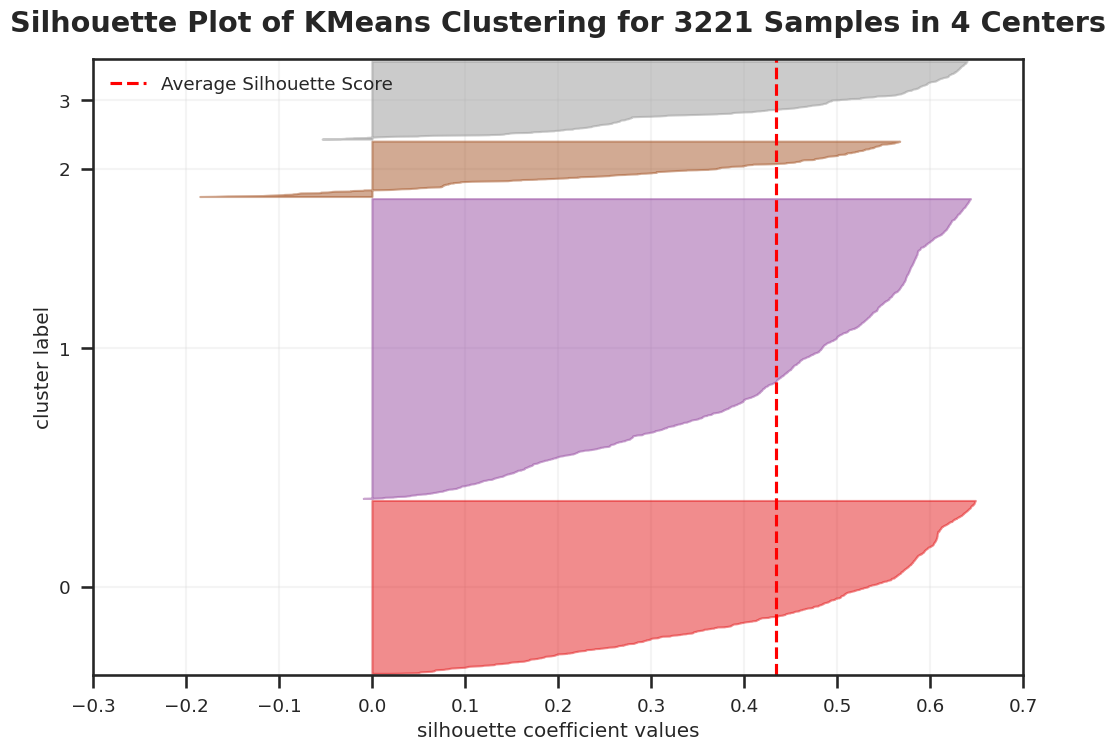

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3221 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4))

In [ ]:
silhouette_visualizer(KMeans,x)

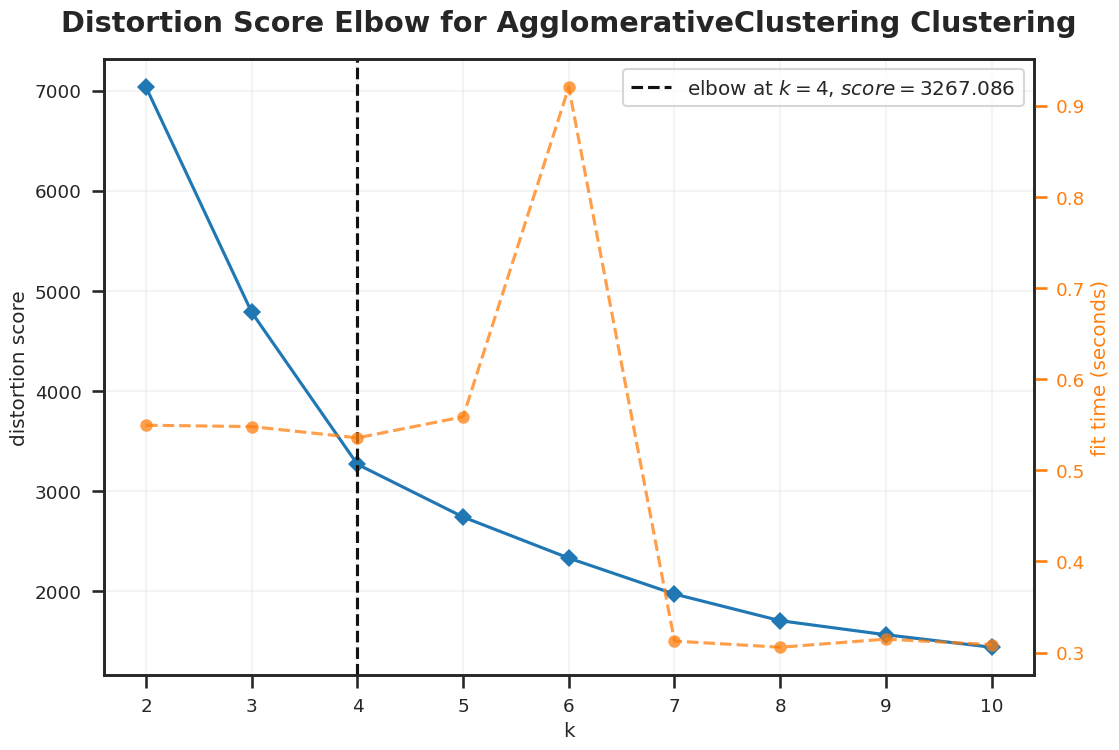

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10))

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), rfm_clip_scaled, k = 10, timing = True)

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
x = rfm_clip_scaled

for k in range (2,11):
  model = AgglomerativeClustering(n_clusters = k)
  labels = model.fit_predict(x)
  cluster_results_dict = {"k": k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(x, labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

pd.DataFrame(cluster_metrics_results).set_index("k").style.background_gradient(axis = 0)

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.275504,1.175722,1201.326193
3,0.349059,0.961407,1639.663827
4,0.375710,0.861049,2099.287388
5,0.387128,0.784646,2031.300741
6,0.313115,0.843280,2024.302594
7,0.331633,0.948306,2091.762208
8,0.317007,0.949007,2144.634355
9,0.309112,0.969508,2080.718378
10,0.305678,0.941910,2039.962954


In [ ]:
hclust = AgglomerativeClustering(n_clusters = 4)
hclust_labels = hclust.fit_predict(rfm_clip_scaled)

In [ ]:
px.scatter_3d(data_frame = rfm_clip, x = "frequency", y = "recency", z = "monetary", color = hclust_labels.astype(str))

In [ ]:
results = []
k_range = range( 1,9 )
covariance_types = ["full", "tied", "diag", "spherical"]
x = rfm_clip_scaled
for n_components in k_range:
  for covariance_type in covariance_types:
    nclust = GaussianMixture(n_components = n_components, n_init = 3,  warm_start = True, covariance_type = covariance_type)
    nclust.fit(x)
    results.append({
        "bic":nclust.bic(x),
        "n_components": n_components,
        "covariance": covariance_type,
        })

results = pd.DataFrame(results)
results.sort_values("bic").head()

,bic,n_components,covariance
30,-6843.277899,8,diag
28,-2772.232684,8,full
26,-2765.430386,7,diag
24,-2694.314867,7,full
20,-2236.772136,6,full


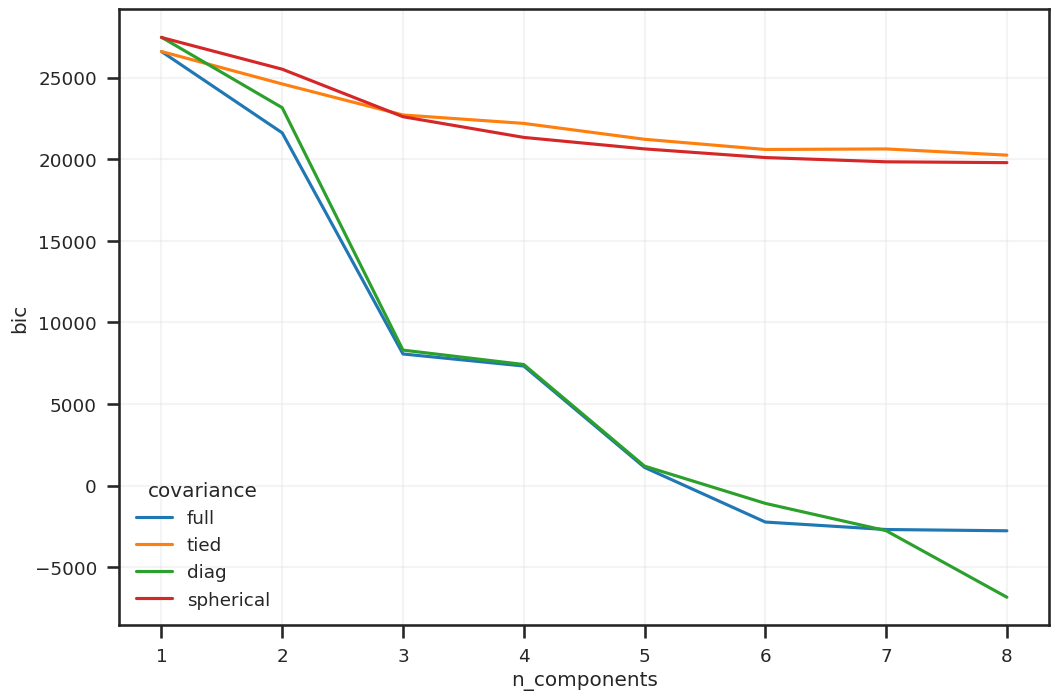

In [ ]:
sns.lineplot(data = results, x = "n_components", y = "bic", hue = "covariance");

In [ ]:
nclust = GaussianMixture(n_components = 5, covariance_type = "diag", n_init = 10)
nclust_labels = nclust.fit_predict(x)

In [ ]:
px.scatter_3d(data_frame = rfm_clip, x = "frequency", y = "recency", z = "monetary", color = nclust_labels.astype(str))

In [ ]:
centers = pd.DataFrame(KMeans.cluster_centers_, columns = rfm_clip_scaled.columns)
centers

,recency,frequency,monetary
0,1.267656,-0.609784,-0.325104
1,-0.518161,-0.203780,-0.299002
2,0.061126,0.077184,2.721146
3,-0.863712,2.082715,-0.066804


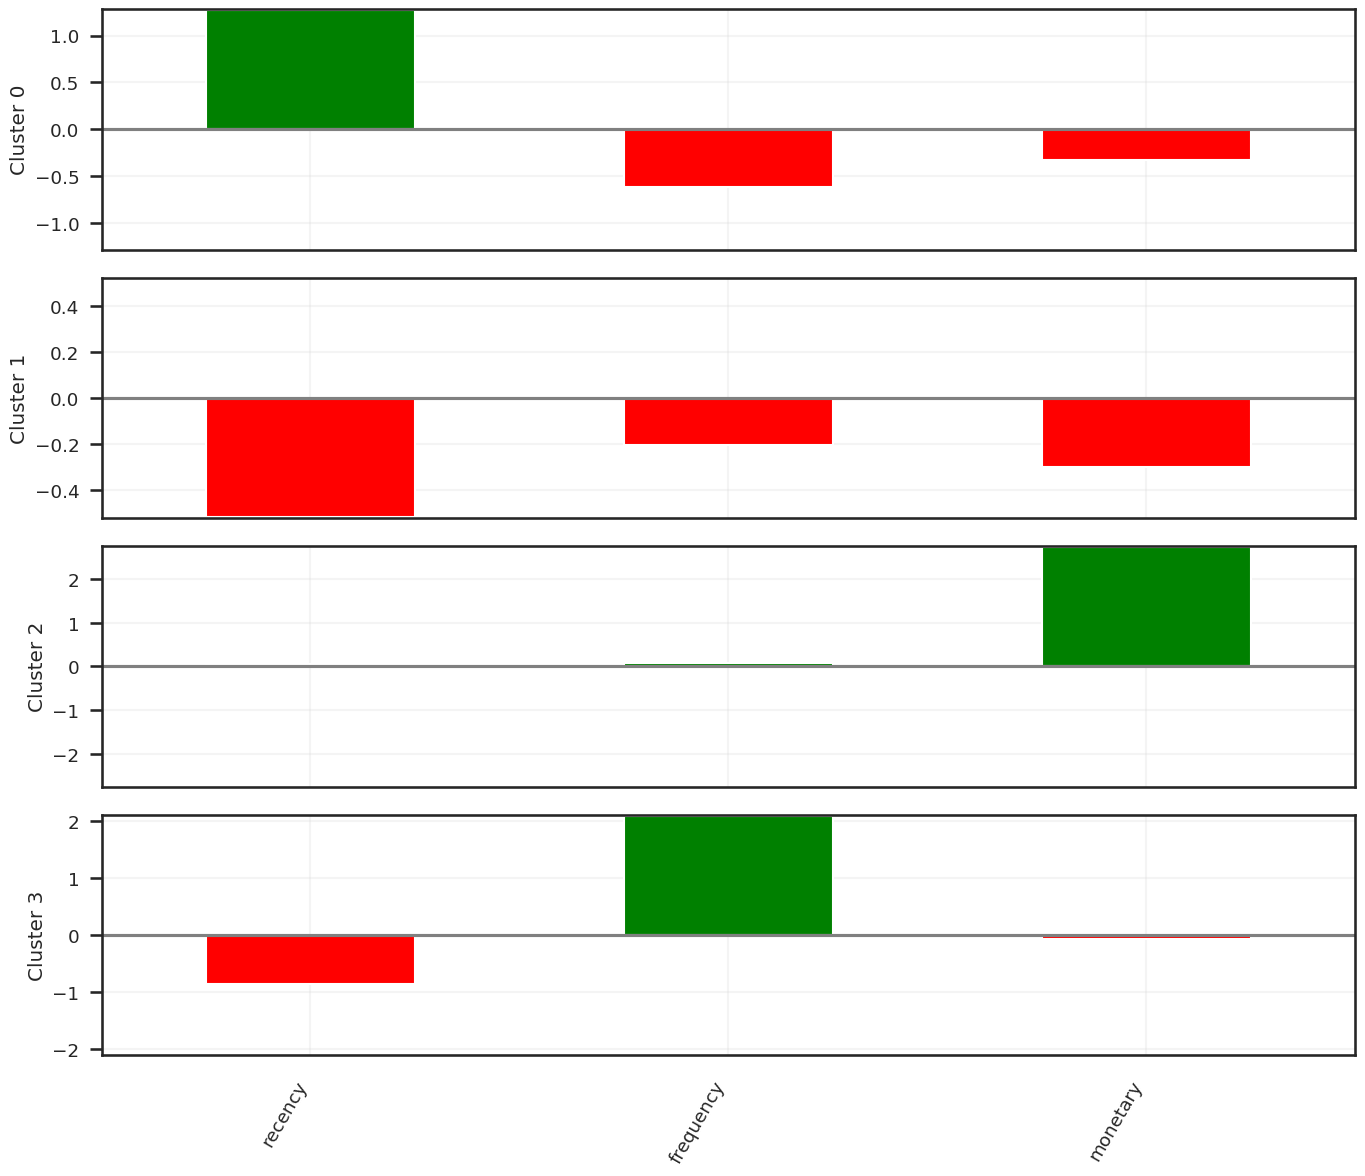

In [ ]:
fig,axes = plt.subplots(nrows = 4, figsize = (14,12), sharex = True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax = ax, color = colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color = 'gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation = 60, ha = 'right')
plt.tight_layout()
plt.show()

In [ ]:
df_cluster_perc = (pd.DataFrame(Kmeans_labels)
.value_counts()
.div(len(rfm_clip_scaled))*100)
df_cluster_perc=df_cluster_perc.apply(lambda x: f"{x:.2f}%")

df_cluster_perc

1    49.46%
0    28.53%
3    12.85%
2     9.16%
dtype: object